<a href="https://colab.research.google.com/github/wmokrogulski/intro-to-dl/blob/main/intro_to_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set tf 1.x for colab
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
setup_google_colab.setup_week2()
# setup_google_colab.setup_week2_honor()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

--2021-04-27 09:10:55--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2021-04-27 09:10:55 (37.2 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
**************************************************
cifar-10-batches-py.tar.gz
**************************************************
mnist.npz


# Intro to TensorFlow

This notebook covers the basics of TF and shows you an animation with gradient descent trajectory.
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week2/v2/images/gradient_descent.png?raw=1" style="width:50%">

# TensorBoard

**Plase note that if you are running on the Coursera platform, you won't be able to access the tensorboard instance due to the network setup there.**

Run `tensorboard --logdir=./tensorboard_logs --port=7007` in bash.

If you run the notebook locally, you should be able to access TensorBoard on http://127.0.0.1:7007/

In [18]:
# !!! RUN THIS CELL ONLY ON GOOGLE COLAB !!!
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab

# run tensorboard in background
import os
os.system("tensorboard --logdir=./tensorboard_logs --host 0.0.0.0 --port 7007 &")

# expose port and show the link
setup_google_colab.expose_port_on_colab(7007)

--2021-04-27 09:26:12--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2021-04-27 09:26:12 (29.3 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

Port 7007 is closed, retrying...
Open http://7987ef4fcb23.ngrok.io to access your 7007 port


In [4]:
import tensorflow as tf
import sys
sys.path.append("../..")
from keras_utils import reset_tf_session
s = reset_tf_session()
print("We're using TF", tf.__version__)

Using TensorFlow backend.








We're using TF 1.15.2


# Warming up
For starters, let's implement a python function that computes the sum of squares of numbers from 0 to N-1.

In [5]:
import numpy as np

def sum_python(N):
    return np.sum(np.arange(N)**2)

In [6]:
%%time
sum_python(10**5)

CPU times: user 1.62 ms, sys: 1.25 ms, total: 2.86 ms
Wall time: 6.49 ms


333328333350000

# Tensoflow teaser

Doing the very same thing

In [20]:
# An integer parameter
N = tf.placeholder('int64', name="input_to_your_function")

# A recipe on how to produce the same result
result = tf.reduce_sum(tf.range(N)**2)

In [21]:
# just a graph definition
result

<tf.Tensor 'Sum_1:0' shape=() dtype=int64>

In [22]:
%%time
# actually executing
result.eval({N: 10**5})

CPU times: user 7.4 ms, sys: 1.76 ms, total: 9.17 ms
Wall time: 10.1 ms


333328333350000

In [23]:
# logger for tensorboard
writer = tf.summary.FileWriter("tensorboard_logs", graph=s.graph)

# How does it work?
1. Define placeholders where you'll send inputs
2. Make a symbolic graph: a recipe for mathematical transformation of those placeholders
3. Compute outputs of your graph with particular values for each placeholder
  * `output.eval({placeholder: value})`
  * `s.run(output, {placeholder: value})`

So far there are two main entities: "placeholder" and "transformation" (operation output)
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be int32/64, floats, booleans (uint8) of various size.

* You can define new transformations as an arbitrary operation on placeholders and other transformations
 * `tf.reduce_sum(tf.arange(N)**2)` are 3 sequential transformations of placeholder `N`
 * There's a tensorflow symbolic version for every numpy function
   * `a+b, a/b, a**b, ...` behave just like in numpy
   * `np.mean` -> `tf.reduce_mean`
   * `np.arange` -> `tf.range`
   * `np.cumsum` -> `tf.cumsum`
   * If you can't find the operation you need, see the [docs](https://www.tensorflow.org/versions/r1.3/api_docs/python).
   
`tf.contrib` has many high-level features, may be worth a look.

In [24]:
with tf.name_scope("Placeholders_examples"):
    # Default placeholder that can be arbitrary float32
    # scalar, vertor, matrix, etc.
    arbitrary_input = tf.placeholder('float32')

    # Input vector of arbitrary length
    input_vector = tf.placeholder('float32', shape=(None,))

    # Input vector that _must_ have 10 elements and integer type
    fixed_vector = tf.placeholder('int32', shape=(10,))

    # Matrix of arbitrary n_rows and 15 columns
    # (e.g. a minibatch of your data table)
    input_matrix = tf.placeholder('float32', shape=(None, 15))
    
    # You can generally use None whenever you don't need a specific shape
    input1 = tf.placeholder('float64', shape=(None, 100, None))
    input2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

    # elementwise multiplication
    double_the_vector = input_vector*2

    # elementwise cosine
    elementwise_cosine = tf.cos(input_vector)

    # difference between squared vector and vector itself plus one
    vector_squares = input_vector**2 - input_vector + 1

In [25]:
my_vector =  tf.placeholder('float32', shape=(None,), name="VECTOR_1")
my_vector2 = tf.placeholder('float32', shape=(None,))
my_transformation = my_vector * my_vector2 / (tf.sin(my_vector) + 1)

In [26]:
print(my_transformation)

Tensor("truediv_1:0", shape=(?,), dtype=float32)


In [27]:
dummy = np.arange(5).astype('float32')
print(dummy)
my_transformation.eval({my_vector: dummy, my_vector2: dummy[::-1]})

[0. 1. 2. 3. 4.]


array([0.       , 1.6291324, 2.0950115, 2.6289961, 0.       ],
      dtype=float32)

In [28]:
writer.add_graph(my_transformation.graph)
writer.flush()

TensorBoard allows writing scalars, images, audio, histogram. You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz).

# Summary
* Tensorflow is based on computation graphs
* A graph consists of placeholders and transformations

# Loss function: Mean Squared Error

Loss function must be a part of the graph as well, so that we can do backpropagation.

In [35]:
with tf.name_scope("MSE"):
    y_true = tf.placeholder("float32", shape=(None,), name="y_true")
    y_predicted = tf.placeholder("float32", shape=(None,), name="y_predicted")
    # Implement MSE(y_true, y_predicted), use tf.reduce_mean(...)
    # mse = ### YOUR CODE HERE ###
    mse=tf.reduce_mean((y_true-y_predicted)**2)

def compute_mse(vector1, vector2):
    return mse.eval({y_true: vector1, y_predicted: vector2})

In [30]:
writer.add_graph(mse.graph)
writer.flush()

In [36]:
# Rigorous local testing of MSE implementation
import sklearn.metrics
for n in [1, 5, 10, 10**3]:
    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(sklearn.metrics.mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            if not np.allclose(true_mse, my_mse):
                print('mse(%s,%s)' % (el, el_2))
                print("should be: %f, but your function returned %f" % (true_mse, my_mse))
                raise ValueError('Wrong result')

# Variables

Placeholder and transformation values are not stored in the graph once the execution is finished. This isn't too comfortable if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 
 

In [37]:
# Creating a shared variable
shared_vector_1 = tf.Variable(initial_value=np.ones(5),
                              name="example_variable")

In [38]:
# Initialize variable(s) with initial values
s.run(tf.global_variables_initializer())

# Evaluating the shared variable
print("Initial value", s.run(shared_vector_1))

Initial value [1. 1. 1. 1. 1.]


In [39]:
# Setting a new value
s.run(shared_vector_1.assign(np.arange(5)))

# Getting that new value
print("New value", s.run(shared_vector_1))

New value [0. 1. 2. 3. 4.]


# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* True to its name it can manage matrix derivatives
* Gradients are computed as a product of elementary derivatives via the chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

In [40]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar**2

# A derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar, ])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [41]:
derivative

[<tf.Tensor 'gradients/pow_2_grad/Reshape:0' shape=<unknown> dtype=float32>]

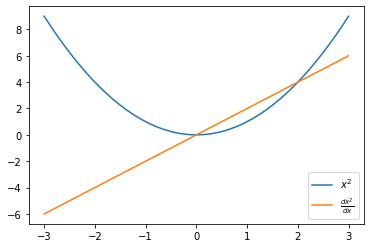

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
x_squared, x_squared_der = s.run([scalar_squared, derivative[0]],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="$x^2$")
plt.plot(x, x_squared_der, label=r"$\frac{dx^2}{dx}$")
plt.legend();

# Why that rocks

In [44]:
my_vector = tf.placeholder('float32', [None])
# Compute the gradient of the next weird function over my_scalar and my_vector
# Warning! Trying to understand the meaning of that function may result in permanent brain damage
weird_psychotic_function = tf.reduce_mean(
    (my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 
    1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(
    2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2
                      )*tf.exp((my_scalar-4)**2)/(
    1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2)
                                    )/(1+tf.exp(-(my_scalar-4)**2)))**2

der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)

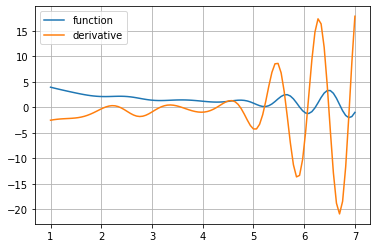

In [45]:
# Plotting the derivative
scalar_space = np.linspace(1, 7, 100)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar,
                         {my_scalar:x, my_vector:[1, 2, 3]})
                   for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

# Almost done - optimizers

While you can perform gradient descent by hand with automatic gradients from above, tensorflow also has some optimization methods implemented for you. Recall momentum & rmsprop?

In [46]:
y_guess = tf.Variable(np.zeros(2, dtype='float32'))
y_true = tf.range(1, 3, dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + 0.5*tf.random_normal([2]))**2) 

step = tf.train.MomentumOptimizer(0.03, 0.5).minimize(loss, var_list=y_guess)

Let's draw a trajectory of a gradient descent in 2D

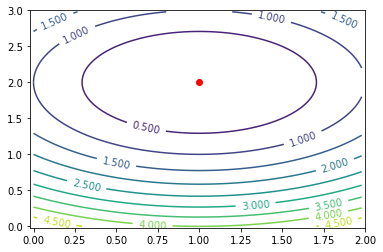

In [48]:
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html

# nice figure settings
fig, ax = plt.subplots()
y_true_value = s.run(y_true)
level_x = np.arange(0, 2, 0.02)
level_y = np.arange(0, 3, 0.02)
X, Y = np.meshgrid(level_x, level_y)
Z = (X - y_true_value[0])**2 + (Y - y_true_value[1])**2
ax.set_xlim(-0.02, 2)
ax.set_ylim(-0.02, 3)
s.run(tf.global_variables_initializer())
ax.scatter(*s.run(y_true), c='red')
contour = ax.contour(X, Y, Z, 10)
ax.clabel(contour, inline=1, fontsize=10)
line, = ax.plot([], [], lw=2)

# start animation with empty trajectory
def init():
    line.set_data([], [])
    return (line,)

trajectory = [s.run(y_guess)]

# one animation step (make one GD step)
def animate(i):
    s.run(step)
    trajectory.append(s.run(y_guess))
    line.set_data(*zip(*trajectory))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [49]:
try:
    display_html(HTML(anim.to_html5_video()))
except (RuntimeError, KeyError):
    # In case the build-in renderers are unaviable, fall back to
    # a custom one, that doesn't require external libraries
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABNim1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAADHoZYiE
ACv//vZzfAprRzOVLgV292aj5dCS5fsQYPrQAAADAAGq1jzipe3VQKREMzn+ud2GzbOJ43BPcMYj
i93Y+Em0ioSb+61aEWEM7dcbRaivTOm4o+VA8ddAAAAFKlUSisUnKcUIhincww6T5PkKpaK19RDU
XBPH/pmpmIqHtCYyZf8TZNeLqtLPBRS0zroJvm/0WhHZqHT4sVJ1A0QYyaRH3tm9j8pH6isGYwLm
p80b8MFL5upDVMndNVIe0lPtZtq21Dpj84mws4mZKNEZVvfHjNmlvtN2GMNO5l4ylcOc33zCq1wk
LPnp9m84I6D4NP3kYl7Qq59cuOH75TPx64OS7N4Z0DPeUwuOKqaVoPrXKk4mlhXQrU6jhfvC6QjJ
cQhID7TroGsiNeMxdj8GZGCcPPTtxLa0QEWdQjVZEBd4+mMYwV/aOk2fsfT57cp18uVynvzjd/Eh
E81ZKCMtDSiVmpEUsM143oeaGZxPgU5d+UImDim3Kf9X6RiArcbric5Rhm+DjNnncfDklslLzSH4
o5ikhdkEjH491aNhpc96SiUcMErPRih5z+TUfhvZSoCJFl+5eJCYjlJ4Gru7LQf7d3M4lHcjjcZP
magiNyPja5G+MwpcF5+QwdE1XnMUcOLtFxgWuJbuPlXjjh/48o6kKsls5by4V8xeDWf6a89zSK0n
YT4qUZhw1ppSO/Z0rdcf+Pj5fvJI1Qx3b72qFnH9ANCQ5JgTOxcCgR69zhsBlnSI2YRrVse2RzDa
l/6haZgQ/xOer8hyagGeoS0bi0VvDqowymUbMOPCCvxix0OL5k7hcmsAC719jERyfWPDRNoT9O8n
aOIlZgEa/OxPHBuhUE42xwOtgcvL9K0bS7ZYaJZQpjahyfmQebROPBosX3BT9HoXzh5PXxi4RSYa
eULslQ0xUiFosCTf7PTz+OsQvxfdw07zXLcNeMKcBndgDTwL9g18xAO2HOQAx1masSRDxDKmy5pS
sJ+n4bh/JYP0wDXIyHEllcwCbWURd2bX72uBCmxeCesN6gnY7guDnjjIP3uWlOv7m2bw8Ki5Kv8F
5RpcuVMZ6SDyLifPQLfZ55p2IDQ8uKG784jOXJtX2TFq8KoCNe0fFHs3NAXy2pAYFAsRVES3r+9E
li/FJts1BjJWjKhIuMDQLhYUqHvkNHsGQme4OYRtRpaBZ/65VOKA1xT/nsM1tiVzohcqSOX1xAj6
H3IioGANND8iJhOeRo14AtWToMwba3NJx/fEOOmnuDS/+NdbNNp9cEpE/cAFv1kGfFI9Ks8h/JCj
ACt8XgilW746gKUuwGu/FP7LDd8MWPRCE4ZLlL2UxUGhiH+pENg5a5cSU2HBWBcG4fdtChPWJ/t1
EpJ1uRTtwtl4B97je+rMB17BLtOeoB6dw/w5JPE0Ws5vnyQKea+9zulmlJaH1VkhM1f2GhpMPARH
wP5vuYr29tjwh0TVOfbvMVqS6fw/u42xo72aH44SdKG/g1jA4oM0U6GzA2dLe0ZlDpGmuOohUJx6
wKKw145oFHNCpo91ppZuqeJc6O1GQmi4vEdCEkwYaUYVHFcCiNCgQXoMFtYbstAzRFCGAC1HZ26W
DkgbtyX4s+9cgZ/enqy7kLThWDt3iFeIWXnD9+xtHyv6HA/75ppz90N06CZj7iQVhMZadvf+ld6L
G11/m5K7kRuZ+ASZPkCy9HjLllQzUWfc9OVL2drPjcv8GImaWtOiwfpfiXuu1Tiv5tlfEcv2nwQb
SAHRj4wA11VXWH5YDAz6yzNwqHBCJKoICaZnyar6YWMCMarIWcvAs8JUjxYgxqLKHspzv+wGkFSF
v5XknccajRuo9O3W2KYrAtgEkixAaJfhgMS9ejXTRjUWAi8wlTO+YYwYKUguBcWJmMrBUfkso1RC
MOU/vOZLCKv9uGwGICCReGZVXsquxLJUxU8IoQf09p22BKhCavpKoYkqeGsYcgEFkySctImDVN+7
grSUCoJ9hElTBKsczs/eTJkTZtyaMOL+hQ9j45IqsmhraEKuu4XKWaxjPGwND1KH9FTZ349iaOEF
PANd8Sr1jP+lbCgwklDrQD7ALbimDCLE4oQuYDTdwS3PR3VEoLAppCpIToCNlUD30n0IFG/KVhXE
Wqex9dq/NVcWyHUeboYhXKzmmsH5OGHbSlbsQ4kiP0g9emSC16wtp7oGf6WrKiuxnejMhYb8zX//
2Vg4f4Gs4c853bupeaM3olVDs7gTaC/SsgADTESUSpNo+0WSVbTHPW4HTp/J8k+evURVoFl3zLXT
51JtcyISTYH9QJAZvYUaNlWUWV4l2WS3lXEUFmMtp2lpe2Jr1WOJKyY17yv0cBoYA6s9g+577m+g
BbUHlMXRgdnnJny0sd3+wWDJ1X6vtkMQ1m41yyg45LlYNsF317AWo5mt0OPmInU2DPyxJMPF7EWc
9RufIR5ds2yLtlVKIVyhbw9mKpxmSaCBv6dH7eulB4l7pFpD8lKATuKjifAAg0YClJv4xy52cC0o
A2Q1ccgOdmkfx0m2qGfz1sHgefWy3HF04G1CwXsQEMkOezweiWGDoOjPMPngL/kqpi3BLWOiNUa1
nIwFvT+MKFB7ahHF/zNOnek1dVkD+UScIFVyXw1AQ2S2BitOKS268OE6L006ozpcqVE1E738qPzK
Sr9l8FkE2qxzG5RiIo2nfyxwIaOBq7kY0MGlr8j1TR4jRVVdY6+00mqSJ5arhgnuF55AVxoY1H+r
CNAyuo5LOFoXmAOkaGDIWalxGL1Vz0Cvs1OwXeufRRkc3J/PivlpFKpNb6CnJnYx/4xkAbDvIzVr
RH+Dy7LKiLXGkgSsB/8i7Qjj0C3227hhKRbv8qmx6/g59OFBbyAkJg1MgOZrQBv44N8EgTGsPUWH
Q2V2eUr9wYwgHPlpxTtld